### Import Dependencies

In [16]:
import cv2
import csv 
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
import mediapipe

### Loading and Balancing the Dataset

In [2]:
df = pd.read_csv('emotic.csv')

In [3]:
X = df.drop('class', axis=1)
y = df['class'] # target value

In [5]:
smt = SMOTETomek(random_state=42)
X, y = smt.fit_resample(X, y)

### Training the Ensemble Model

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

In [7]:
lg_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
rf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
svc_pipeline = make_pipeline(SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo', probability=True))

In [8]:
estimators = [('lg', lg_pipeline), ('randomForest', rf_pipeline), ('svc', svc_pipeline)]

In [9]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=estimators, voting='soft')

In [10]:
ensemble.fit(X_train, y_train)

C:\Users\norra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 17min 23s


VotingClassifier(estimators=[('lg',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('logisticregression',
                                               LogisticRegression())])),
                             ('randomForest',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('randomforestclassifier',
                                               RandomForestClassifier())])),
                             ('svc',
                              Pipeline(steps=[('svc',
                                               SVC(C=1,
                                                   decision_function_shape='ovo',
                                                   gamma=1,
                                                   probability=True))]))],


In [11]:
y_pred = ensemble.predict(X_test)

Wall time: 32.3 s


In [12]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.9651287553648069


### Model Evaluation Using Confusion Matrix

C:\Users\norra\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\norra\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\norra\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


               precision    recall  f1-score   support

    Annoyance       0.98      0.99      0.99       309
     Aversion       0.99      1.00      1.00       306
Disconnection       0.96      0.98      0.97       284
   Engagement       0.96      0.85      0.90       330
   Excitement       0.94      0.97      0.96       316
     Pleasure       0.95      1.00      0.98       319

     accuracy                           0.97      1864
    macro avg       0.97      0.97      0.97      1864
 weighted avg       0.97      0.97      0.96      1864



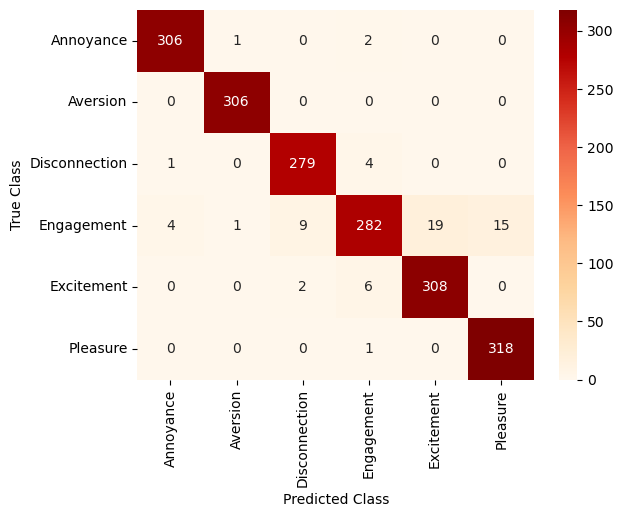

Wall time: 35.7 s


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
y_true = y_test

y_pred = ensemble.predict(X_test.values)

confusion_matrix = confusion_matrix(y_true, y_pred)

sns.heatmap(confusion_matrix, annot=True, fmt='d',
            xticklabels=unique_labels(y_test), yticklabels=unique_labels(y_test), cmap='OrRd')

plt.xlabel('Predicted Class')
plt.ylabel('True Class')

print(classification_report(y_true, y_pred,
      target_names=unique_labels(y_test)))

plt.show()


 ### Predicting Emotion Class using the Ensemble Model on the Captured Videos from the Case Study

In [14]:
# creating csv file to store the case study results
row_em = ['index', 'person', 'class']
with open('case_study_ER_results_ensemble_model.csv', mode='w', newline='') as coords:
    csv_writer = csv.writer(coords, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(row_em)

In [ ]:
# Initializing the landmarks drawing utilities
mp_drawing = mp.solutions.drawing_utils
# Mediapipe landmark detection models
mp_holistic = mp.solutions.holistic
# path to the case study videos 
path = 'C:/Users/norra/Graduation project/case study/all'
emotion_counts = {'Aversion': 0, 'Annoyance': 0, 'Engagement': 0, 'Disconnection': 0, 'Excitement': 0, 'Pleasure': 0}
emotion_classes = []
i =0
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for filename in os.listdir(path):
        if filename.endswith(".mov"):
            video = cv2.VideoCapture(os.path.join(path, filename))
            print(filename)
            person_number = filename[:9]
            emotion_counts = {'Aversion': 0, 'Annoyance': 0, 'Engagement': 0, 'Disconnection': 0, 'Excitement': 0, 'Pleasure': 0}
            # Looping through each frame received from the webcam
            while (video.isOpened()):
                ret, frame = video.read()
                if not ret:
                    print("Can't receive frame (stream end?). Exiting ...")
                    break
                # Convert image color format from BGR to RGB
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False
                # Pass the image to mediapipe for detection
                results = holistic.process(image)

                # Convert the image color format back to BGR for rendering
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Draw face laandmarks 
                mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                          )
                # Draw right hand laandmarks 
                mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                          )
                # Draw left hand laandmarks 
                mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                          )
                # Draw pose laandmarks 
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                          mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                          )

                # Export Coordinates
                try:
                    # Extract pose landmarks
                    pose = results.pose_landmarks.landmark
                    pose_row= list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility]for landmark in pose]).flatten())

                    # Extract face landmarks
                    face = results.face_landmarks.landmark
                    face_row= list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility]for landmark in face]).flatten())

                    # Concate rows
                    row = pose_row + face_row


                    X = pd.DataFrame([row])
                    emotion_class = ensemble.predict(X.values)[0]
                    emotion_counts[emotion_class] += 1

                    # Calculate the majority vote after processing the entire video
                    majority_emotion = max(emotion_counts, key=emotion_counts.get)
                    file = [str(i), person_number, majority_emotion]
                    if [person_number, majority_emotion] not in [file[1:] for file in emotion_classes]:
                        emotion_classes.append(file)
                        i+=1
                    # Grab ear coords
                    coords = tuple(np.multiply(
                                    np.array(
                                        (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y)
                                    ), [640,480]).astype(int))

                except:
                    pass
                


        cv2.imshow('Raw webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

video.release()
cv2.destroyAllWindows()

# Export to CSV
with open('case_study_ER_results_ensemble_model.csv', mode='a', newline='') as coords:
    csv_writer = csv.writer(coords, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for row in emotion_classes:
        csv_writer.writerow(row)